引入所需要的包

In [52]:
import numpy as np
import pandas as pd
from datatrans import load_pr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pyfolio as pf
from Plot_Module import plot_observe_index
import pandas as pd
import datetime

读取回测结果

In [1]:
def data_analysis(load_path, load_exp):
    from datatrans import load_pr
    
    load_path = load_path
    load_exp = load_exp
    r = load_pr(load_path + load_exp)
    #print(r)
    result = r['analyze_result']
    performance = result['df00'] # 绩效指标
    #total_value = result['df0']  # 账户价值
    year_rate = result['df3']  # 年化收益
    total_position_value= result['df4']  # 持仓市值

    pyfoliozer_data = r['pyfoliozer']
    returns = pyfoliozer_data['returns']  # 日度收益
    positions = pyfoliozer_data['positions'] #仓位
    transactions= pyfoliozer_data['transactions'] #仓位变化

    df = {}
    df['performance'] = performance
    #df['total_value'] = total_value
    df['year_rate'] = year_rate
    df['total_position_value'] = total_position_value
    df['returns'] = returns
    df['positions'] = positions
    df['transactions'] = transactions
    return df

def benchmark_data(load_path,load_exp): # 获取指数数据作为benchmark
    load_path = load_path
    load_exp = load_exp
    df = pd.read_csv(load_path+load_exp)
    df['daily_return'] = df['close'].pct_change()
    df = df[['Unnamed: 0','daily_return']]
    df = df.rename(columns={'Unnamed: 0': 'index'})
    df = df.dropna()
    df = df.set_index('index')
    df.index = pd.to_datetime(df.index)
    return df

回测结果文件路径

In [71]:
load_path = '../../raw_data/result/'
# 添加 benchmark
# 添加与中证500 指数的比较：
file_path = '../../raw_data/base/'
file_exp = '000905.XSHG_指数日行情' + '.csv'
df_zz500 = benchmark_data(load_path=file_path,load_exp=file_exp)
# 截取时间段
df_zz500 = df_zz500[(df_zz500.index < datetime.datetime(2021,12,31))
                    &(df_zz500.index > datetime.datetime(2013,1,1))]
df_zz500_ret = df_zz500['daily_return'].tz_localize('UTC') # 计算 daily return

读取指数增强策略回测情况

In [76]:
load_exp_100 = 'mv_TEconstraint_elasticnet_group_one.pr'
df_100 = data_analysis(load_path=load_path,load_exp=load_exp_100)

load_exp_200 = 'mv_TEconstraint_adaboost_group_one.pr'
df_200 = data_analysis(load_path=load_path,load_exp=load_exp_200)

load_exp_300 = 'mv_TEconstraint_GBDT_group_one.pr'
df_300 = data_analysis(load_path=load_path,load_exp=load_exp_300)

load_exp_400 = 'mv_TEconstraint_randomforest_group_one.pr'
df_400 = data_analysis(load_path=load_path,load_exp=load_exp_400)

load_exp_500 = 'mv_TEconstraint_new_minmax_lasso_group_one.pr'
df_500 = data_analysis(load_path=load_path,load_exp=load_exp_500)

load_exp_600 = 'mv_TEconstraint_MLP_group_one.pr'
df_600 = data_analysis(load_path=load_path,load_exp=load_exp_600)

回测收益率展示

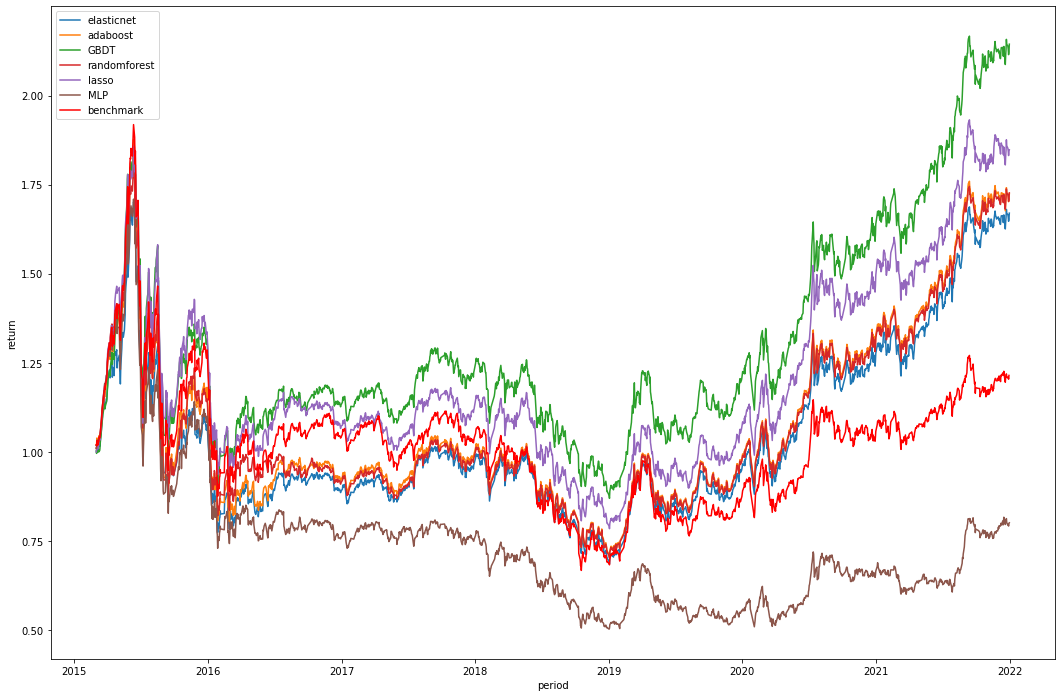

In [77]:
plt.figure(figsize=(18, 12))

plt.plot((1+df_100['returns'][df_100["returns"].index >= "2015-03-01"]).cumprod(), label='elasticnet')
plt.plot((1+df_200["returns"][df_200["returns"].index >= "2015-03-01"]).cumprod(), label='adaboost')
plt.plot((1+df_300["returns"][df_300["returns"].index >= "2015-03-01"]).cumprod(), label='GBDT')
plt.plot((1+df_400["returns"][df_400["returns"].index >= "2015-03-01"]).cumprod(), label='randomforest')
plt.plot((1+df_500['returns'][df_500["returns"].index >= "2015-03-01"]).cumprod(), label='lasso')
plt.plot((1+df_600['returns'][df_600["returns"].index >= "2015-03-01"]).cumprod(), label='MLP')
plt.xlabel('period')
plt.ylabel('return')

plt.plot((1 + df_zz500_ret[df_zz500_ret.index >= "2015-03-01"]).cumprod(),  label='benchmark', color='red')

plt.legend()
plt.show()

In [45]:
# 计算跟踪误差
def cal_tracking_error(fund_Ret, index_Ret, start_date="2012-01-01"):
    fund_ret = fund_Ret
    fund_ret.index = fund_ret.index.astype(str)
    fund_ret = fund_ret[fund_ret.index > start_date]
    
    index_ret = index_Ret
    index_ret.index = index_ret.index.astype(str)
    index_ret = index_ret[index_ret.index > start_date]

    track_error = np.absolute(fund_ret - index_ret).std() * np.sqrt(240)
    
    return track_error

In [18]:
# 读取债券数据
bond_data = pd.read_excel('/home/ubuntu/group_porject/raw_data/base/十年期国债即期收益率.xls', index_col=0, header=4)
bond_data.index.name = 'date'
bond_data = bond_data.rename(columns={'中债估值中心' : 'rf'}).dropna()
bond_data.index = bond_data.index.astype(str).str[:10]
bond_data['rf'] = bond_data['rf']/100/250

In [20]:
en_return = df_100['returns'][df_100['returns'].index > "2019-01-01"]
ada_return = df_200['returns'][df_200['returns'].index > "2019-01-01"]
gbdt_return = df_222['returns'][df_222['returns'].index > "2019-01-01"]
rf_return = df_300['returns'][df_300['returns'].index > "2019-01-01"]
lasso_return = df_400['returns'][df_400['returns'].index > "2019-01-01"]
zz_500_ret = df_zz500_ret[df_zz500_ret.index > "2019-01-01"]
bond_return = bond_data['rf'][bond_data['rf'].index > "2019-01-01"]
print("((((((((收益))))))))")
print(en_return.mean() * 245,
      ada_return.mean() * 245,
      gbdt_return.mean() * 245,
      rf_return.mean() * 245,
      lasso_return.mean() * 245,
      zz_500_ret.mean() * 245
      )
print("((((((((收益波动率))))))))")
print(en_return.std() * np.sqrt(245),
      ada_return.std() * np.sqrt(245),
      gbdt_return.std() * np.sqrt(245),
      rf_return.std() * np.sqrt(245),
      #lasso_return.std() * np.sqrt(245),
      zz_500_ret.std() * np.sqrt(245)
)
print("((((((((夏普比率))))))))")
print(
      ((en_return.mean() - bond_return.mean()) / en_return.std()) * np.sqrt(245),
      ((ada_return.mean() - bond_return.mean()) / ada_return.std()) * np.sqrt(245),
      ((gbdt_return.mean() - bond_return.mean()) / gbdt_return.std()) * np.sqrt(245),
      ((rf_return.mean() - bond_return.mean()) / rf_return.std()) * np.sqrt(245),
      #((lasso_return.mean() - bond_return.mean()) / lasso_return.std()) * np.sqrt(245),
      ((zz_500_ret.mean() - bond_return.mean()) / zz_500_ret.std()) * np.sqrt(245)
)

error_en = cal_tracking_error(en_return, zz_500_ret).mean()
error_ada = cal_tracking_error(ada_return, zz_500_ret).mean()
error_gbdt = cal_tracking_error(gbdt_return, zz_500_ret).mean()
error_rf = cal_tracking_error(rf_return, zz_500_ret).mean()
error_lasso = cal_tracking_error(lasso_return, zz_500_ret).mean()
print("((((((((跟踪误差))))))))")
print(error_en,
      error_ada,
      error_gbdt,
      error_rf,
      error_lasso
      )

((((((((收益))))))))
0.3148091311774614 0.31606743887180444 0.3191876482492676 0.31817399104344896 0.30490999470259483 0.21242637759730087
((((((((收益波动率))))))))
0.21674925615025692 0.21730846940874432 0.21742774139191856 0.21711406242743933 0.21628997538242323
((((((((夏普比率))))))))
1.313698369399224 1.3161081703146993 1.3297367649316878 1.3269891457876524 0.8431291855782705
((((((((跟踪误差))))))))
0.045473997001438594 0.04590420434307961 0.0459753550025244 0.0456477609543576 0.04874918625381584


In [23]:
import statsmodels.formula.api as smf

def cal_strategy_beta(fund_Ret, start_date):
    # 债券日收益率
    bond_data = pd.read_excel('/home/ubuntu/group_porject/raw_data/base/十年期国债即期收益率.xls', index_col=0, header=4)
    bond_data.index.name = 'date'
    bond_data = bond_data.rename(columns={'中债估值中心' : 'rf'}).dropna()
    bond_data.index = bond_data.index.astype(str).str[:10]
    bond_data['rf'] = bond_data['rf']/100/250
    # 市场日收益率
    mkt_data = pd.read_csv('/home/ubuntu/group_porject/raw_data/index_data/000905.XSHG_指数日行情.csv', index_col=0)
    mkt_data['mkt_ret'] = mkt_data['close'].pct_change()
    # 策略日收益率
    fund_Ret = pd.DataFrame(fund_Ret)
    fund_Ret.index = fund_Ret.index.astype(str).map(lambda x : x[:10])
    reg_data = fund_Ret.join(bond_data).join(mkt_data['mkt_ret'])
    # 回归期数据
    reg_data = reg_data[reg_data.index > start_date]
    reg_data['mkt_excess_ret'] = reg_data['mkt_ret'] - reg_data['rf']
    reg_data['index_excess_ret'] = reg_data['return'] - reg_data['rf']

    def regression(x, formula):
        return smf.ols(formula, data=x).fit().params

    beta = regression(reg_data, 'index_excess_ret ~ 1 + mkt_excess_ret').mkt_excess_ret
    return beta

# cal_strategy_beta(df_100["returns"], start_date="2021-01-01")

In [22]:
def cal_strategy_stocks_in_index_weight(strategy_file):
    index_stocks_weight = pd.read_csv("/home/ubuntu/group_porject/raw_data/index_data/000905.XSHG_成分股权重.csv", index_col=0)
    index_stocks_weight = index_stocks_weight.reset_index()
    portfolio_select = pd.read_csv("/home/ubuntu/group_porject/raw_data/strategy/%s" % strategy_file, index_col=0)
    portfolio_select = portfolio_select[portfolio_select["trade_date"] > "2021-01"]
    res_weight = pd.DataFrame(columns=["trade_date", "stocks weight"])
    
    for trade_date in sorted(portfolio_select.trade_date.unique().tolist()):
        index_stocks = index_stocks_weight[index_stocks_weight["trade_date"] == trade_date]
        stra_stocks = portfolio_select[portfolio_select["trade_date"] == trade_date]
        stocks_in_index_weight = index_stocks.merge(stra_stocks, on=["sec_code"])["weight_x"].sum() / 100
        df = pd.DataFrame([[trade_date, stocks_in_index_weight]], columns=["trade_date", "stocks weight"])
        res_weight = pd.concat([res_weight, df])

    return res_weight

读取指数复制策略回测情况

In [79]:
load_exp_1 = '/old result/Analyze_result_multifactor_pre100_weight.pr'
df_1 = data_analysis(load_path=load_path,load_exp=load_exp_1)

load_exp_2 = '/old result/Analyze_result_multifactor_pre200_weight.pr'
df_2 = data_analysis(load_path=load_path,load_exp=load_exp_2)

load_exp_3 = '/old result/Analyze_result_multifactor_pre300_weight.pr'
df_3 = data_analysis(load_path=load_path,load_exp=load_exp_3)

load_exp_4 = '/old result/Analyze_result_multifactor_pre400_weight.pr'
df_4 = data_analysis(load_path=load_path,load_exp=load_exp_4)

load_exp_5= '/old result/Analyze_result_multifactor_pre500_weight.pr'
df_5 = data_analysis(load_path=load_path,load_exp=load_exp_5)

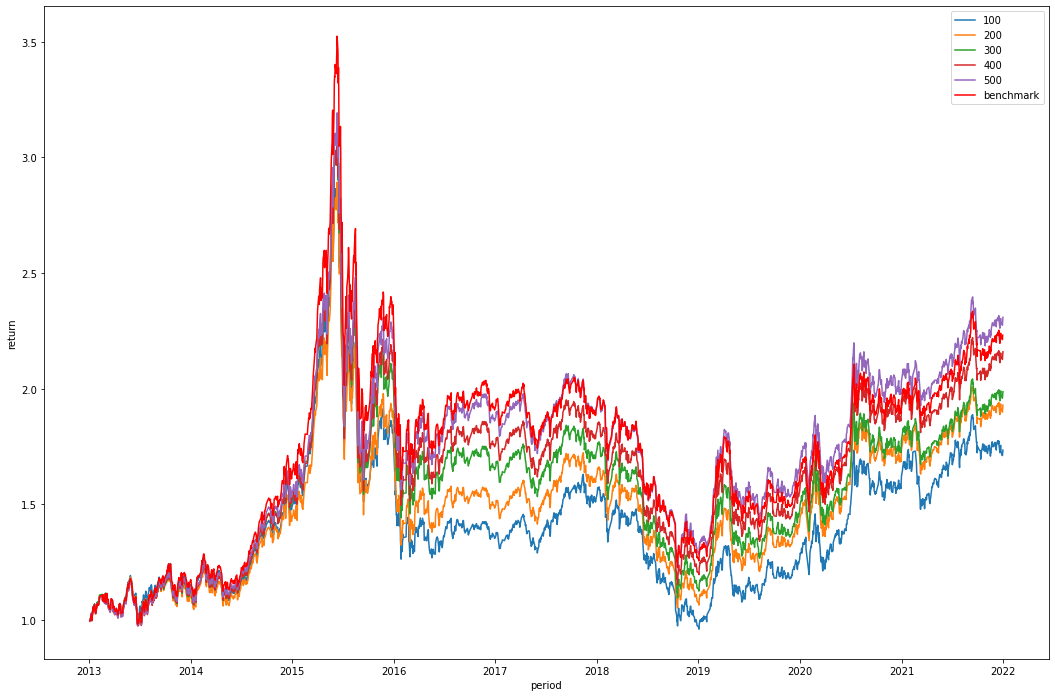

In [81]:
plt.figure(figsize=(18, 12))

plt.plot((1+df_1['returns']).cumprod(), label='100')
plt.plot((1+df_2["returns"]).cumprod(), label='200')
plt.plot((1+df_3["returns"]).cumprod(), label='300')
plt.plot((1+df_4["returns"]).cumprod(), label='400')
plt.plot((1+df_5['returns']).cumprod(), label='500')

plt.xlabel('period')
plt.ylabel('return')

plt.plot((1 + df_zz500_ret).cumprod(),  label='benchmark', color='red')

plt.legend()
plt.show()

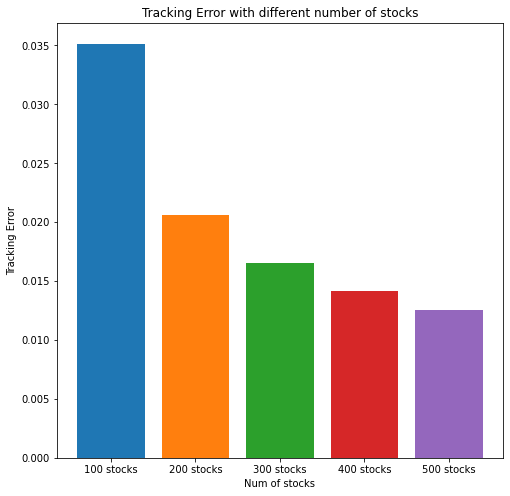

In [64]:
error_100 = cal_tracking_error(df_1['returns'], df_zz500_ret).mean()
error_200 = cal_tracking_error(df_2['returns'], df_zz500_ret).mean()
error_300 = cal_tracking_error(df_3['returns'], df_zz500_ret).mean()
error_400 = cal_tracking_error(df_4['returns'], df_zz500_ret).mean()
error_500 = cal_tracking_error(df_5['returns'], df_zz500_ret).mean()

y_data = [error_100, error_200, error_300, error_400, error_500]
x_data = ['100 stocks', '200 stocks', '300 stocks', '400 stocks', '500 stocks']

import matplotlib.pyplot as plt
 
plt.rcParams["font.sans-serif"]=['SimHei']
plt.rcParams["axes.unicode_minus"]=False
plt.figure(figsize=(8,8)) 
 
for i in range(len(x_data)):
    plt.bar(x_data[i],y_data[i], )
 
plt.title("Tracking Error with different number of stocks")
plt.xlabel("Num of stocks")
plt.ylabel("Tracking Error")

plt.savefig('../../raw_data/result/error_comparison_weight_new.jpg') 
plt.show()

In [62]:
# 计算跟踪误差时序数据
def cal_time_series_TE(fund_Ret, index_Ret, start_date="2012-01-01"):
    fund_ret = fund_Ret
    fund_ret.index = fund_ret.index.astype(str)
    fund_ret = fund_ret[fund_ret.index > start_date]
    
    index_ret = index_Ret
    index_ret.index = index_ret.index.astype(str)
    index_ret = index_ret[index_ret.index > start_date]
    
    track_error = np.square((fund_ret - index_ret)*245)
    
    return track_error

In [57]:
def plot_error_ts(df_ret, track_ret):
    error = cal_time_series_TE(df_ret["returns"], track_ret)
    data_dict = {"error" : error, "zz500_ret" : track_ret}
    error_df = pd.DataFrame(data_dict)
    error_df["zz500_ret"] = (1+error_df["zz500_ret"]).cumprod()
    error_df.index = error_df.index.map(lambda x : x[:10])
    ax = error_df.plot(secondary_y=['zz500_ret'], grid=True, figsize=(20,10), x_compat=False)
    ax.set_title("error-zz500_ret")
    ax.set_xlabel("date")
    ax.set_ylabel('error')
    ax.right_ax.set_ylabel('zz500_ret')
    tick_spacing = error_df.index.size / 9 
    ax.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
    # plt.savefig("/home/ubuntu/group_porject/raw_data/result/ts_error_zz500ret.jpg")
    plt.show()

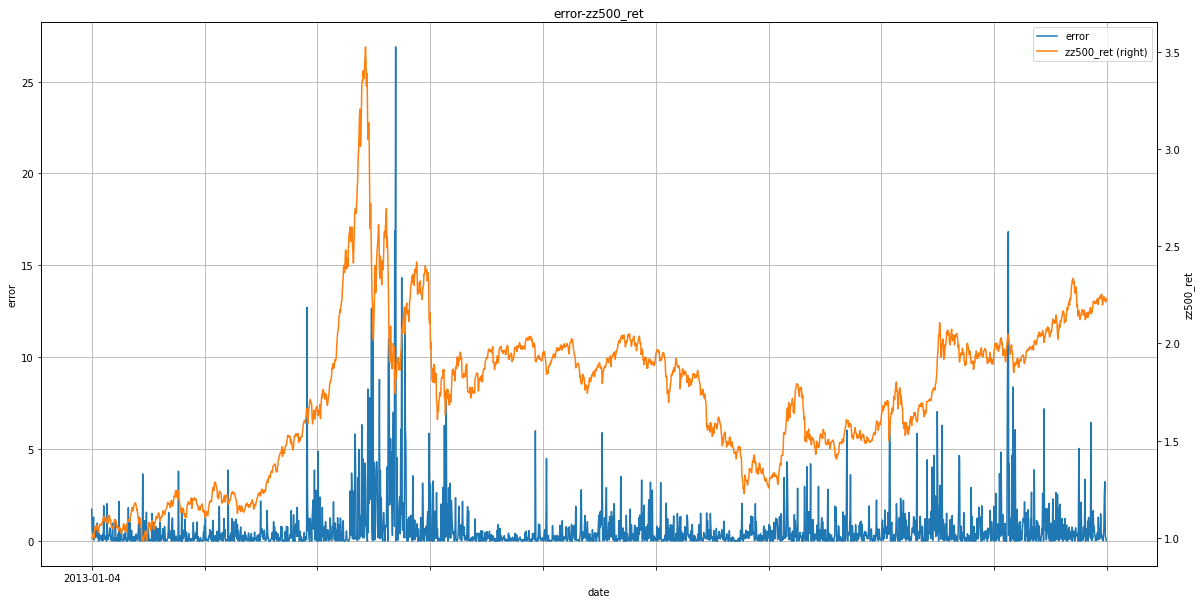

In [63]:
plot_error_ts(df_1, df_zz500_ret)

In [27]:
df_1['returns'] = df_1['returns'][df_1['returns'].index > "2019-01"]
df_2['returns'] = df_2['returns'][df_2['returns'].index > "2019-01"]
df_3['returns'] = df_3['returns'][df_3['returns'].index > "2019-01"]
df_4['returns'] = df_4['returns'][df_4['returns'].index > "2019-01"]
df_5['returns'] = df_5['returns'][df_5['returns'].index > "2019-01"]
df_zz500_ret = df_zz500_ret[df_zz500_ret.index > "2019-01"]
bond_data['rf'] = bond_data['rf'][bond_data['rf'].index > "2019-01"]
print(df_1['returns'].mean() * 245,
      df_2['returns'].mean() * 245,
      df_3['returns'].mean() * 245,
      df_4['returns'].mean() * 245,
      df_5['returns'].mean() * 245,
      df_zz500_ret.mean() * 245
      )

print(df_1['returns'].std() * np.sqrt(245),
      df_2['returns'].std() * np.sqrt(245),
      df_3['returns'].std() * np.sqrt(245),
      df_4['returns'].std() * np.sqrt(245),
      df_5['returns'].std() * np.sqrt(245),
      df_zz500_ret.std() * np.sqrt(245)
)

print(
      ((df_1['returns'].mean() - bond_data['rf'].mean()) / df_1['returns'].std()) * np.sqrt(245),
      ((df_2['returns'].mean() - bond_data['rf'].mean()) / df_2['returns'].std()) * np.sqrt(245),
      ((df_3['returns'].mean() - bond_data['rf'].mean()) / df_3['returns'].std()) * np.sqrt(245),
      ((df_4['returns'].mean() - bond_data['rf'].mean()) / df_4['returns'].std()) * np.sqrt(245),
      ((df_5['returns'].mean() - bond_data['rf'].mean()) / df_5['returns'].std()) * np.sqrt(245),
      ((df_zz500_ret.mean() - bond_data['rf'].mean()) / df_zz500_ret.std()) * np.sqrt(245)
)

error_100 = cal_tracking_error(df_1['returns'], df_zz500_ret).mean()
error_200 = cal_tracking_error(df_2['returns'], df_zz500_ret).mean()
error_300 = cal_tracking_error(df_3['returns'], df_zz500_ret).mean()
error_400 = cal_tracking_error(df_4['returns'], df_zz500_ret).mean()
error_500 = cal_tracking_error(df_5['returns'], df_zz500_ret).mean()

print(error_100,
      error_200,
      error_300,
      error_400,
      error_500
      )

0.2189144886291303 0.21856763833191833 0.21116044381900162 0.21863516245769457 0.21720675713564713 0.21242637759730087
0.22616070174315756 0.2186330519549353 0.21930498176036844 0.21823614254800022 0.21642951363774574 0.21628997538242323
0.8350190831969757 0.8621827753948115 0.8257653590947918 0.8640602489197924 0.8646730623093505 0.8431291855782705
0.0342786179496435 0.020470795532722654 0.016147732030710907 0.013502373399218923 0.01217720827278166


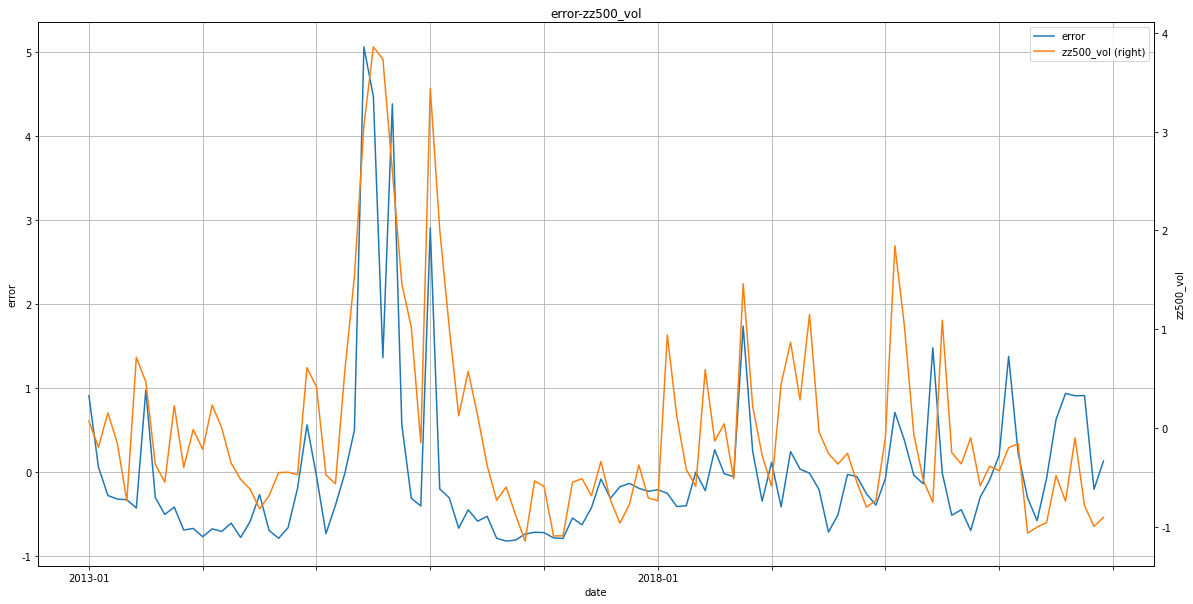

,error,zz500_vol
error,1.000000,0.462989
zz500_vol,0.462989,1.000000


In [66]:
def cal_corr_std_ret(df_ret, track_ret):
    error = cal_time_series_TE(df_ret["returns"], track_ret)
    data_dict = {"error" : error, "zz500_ret" : track_ret}
    error_df = pd.DataFrame(data_dict)
    error_df.index = error_df.index.map(lambda x : x[:10])
    error_df["date"] = error_df.index.map(lambda x : x[:7])
    error_df = error_df.groupby("date").agg({"error" : "mean", "zz500_ret": "std"})
    error_df["error"] = (error_df["error"] - error_df["error"].mean()) / error_df["error"].std()
    error_df["zz500_ret"] = (error_df["zz500_ret"] - error_df["zz500_ret"].mean()) / error_df["zz500_ret"].std()

    error_df = error_df.rename(columns={"zz500_ret" : "zz500_vol"})

    ax = error_df.plot(secondary_y=['zz500_vol'], grid=True, figsize=(20,10), x_compat=False)
    ax.set_title("error-zz500_vol")
    ax.set_xlabel("date")
    ax.set_ylabel('error')
    ax.right_ax.set_ylabel('zz500_vol')
    tick_spacing = error_df.index.size / 9 
    ax.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
    # plt.savefig("/home/ubuntu/group_porject/raw_data/result/ts_error_zz500ret.jpg")
    plt.show()
    
    return error_df

df = cal_corr_std_ret(df_5, df_zz500_ret)
df["error"] = df["error"].shift(-1)
df.corr()